# ML T-Generation Занятие 3: Линейная регрессия.
# Проблема переобучения. Кросс-валидация и регуляризация.

Авторы: Гаркавый Андрей (andrewgarkavyy@gmail.com), Кирилл Васильев (kirivasile@yandex.ru)

Переработал: Чайников Константин (chainikov.k.m@gmail.com)

## 0. План

1. Линейная регрессия

2. Приближение многочленом

3. Переобучение

4. Выводы

5. Разделение на тренировочную и тестовую части

6. Кросс-валидация

7. Как подбираются коэффициенты

8. Регуляризация



## 1. Линейная регрессия
**Регрессией** называется задача машинного обучения с учителем, в которой у нас есть много объектов с признаками, у которых надо научиться приближенно предсказывать значение целевой функции, которая равна какому-то **действительному числу**. 

В этом будет отличие задачи регрессии от задачи классификации - регрессия предсказывает число, а классификация - один из нескольких классов.**Текст, выделенный полужирным шрифтом**

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import warnings
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
model = LinearRegression(fit_intercept=True)

Давайте положим в X какие-то трехмерные векторы.

In [3]:
X = np.ones((200,3))

X[:,1]*=np.random.normal(0,1,(200,))
X[:,2]*=np.random.normal(0,1,(200,))
X[:10]

array([[ 1.        , -0.65273646,  0.07438209],
       [ 1.        ,  2.61769294, -0.63491971],
       [ 1.        ,  0.07687112,  0.03171092],
       [ 1.        , -0.06445364,  0.42660011],
       [ 1.        ,  0.75076998, -1.81252514],
       [ 1.        ,  0.43358598, -0.96104193],
       [ 1.        ,  0.98277781,  2.03350327],
       [ 1.        ,  0.8093621 , -0.70091444],
       [ 1.        ,  1.03731846,  1.44004594],
       [ 1.        ,  0.95470177,  0.40594014]])

Построим $y$ по такой формуле:

$$y = 50 + 14x_1 - 7x_2  + \varepsilon$$

Где $\varepsilon$ - это какой-то шум с нормальным распределением с дисперсией 5, чтобы линейная формула не была уж совсем точной.

In [4]:
y = X @ np.array([50,14,-7]) + np.random.normal(0,5,(200,))
y[:10]

array([45.16600637, 88.55642072, 57.11427256, 48.05240999, 72.9501563 ,
       63.60955472, 41.03072041, 70.98956796, 59.84092348, 63.72114755])

Теперь обучим на этих данных линейную регрессию и посмотрим, сможет ли она восстановить параметры модели $50, 14, -7$.

In [5]:
model.fit(X[:,[1,2]], y)

LinearRegression()

In [6]:
coefs = model.coef_
coefs

array([13.79489622, -6.42287479])

In [7]:
const = model.intercept_
const

49.85482322672188

In [8]:
np.linalg.inv(X.T @ X) @ X.T @ y 

array([49.85482323, 13.79489622, -6.42287479])

In [9]:
# X = np.ones((200,3))
# X[:,1]*=np.random.normal(0,1,(200,))
# X[:,2]*=np.random.normal(0,1,(200,))

# y = X @ np.array([50,14,-7]) + np.random.normal(0,5,(200,))

In [10]:
import plotly.express as px
import plotly.graph_objects as go


fig = px.scatter_3d(np.concatenate((X,y.reshape(-1,1)), axis=1),  x=1, y=2, z=3,
                    size_max=5, opacity=0.5, color_discrete_sequence=['red'])

# tight layout
fig.update_layout(margin=dict(l=10, r=100, b=100, t=10))

x1 = np.linspace(-3, 3, 30)
y1 = np.linspace(-3, 3, 30)
xx, yy = np.meshgrid(x1, y1)
z = np.c_[xx.ravel(), yy.ravel()] @ np.array(coefs[0:2]) + const 

# transpose
z = z.reshape(xx.shape)
fig.add_traces(go.Surface(x=x1, y=y1, z=z, showscale=False,
                          opacity=0.3, colorscale=[[0, 'rgb(0,0,255)'], [1, 'rgb(0,0,255)']]))
fig.show()

И внезапно линейная регрессия как-то примерно угадала наши коэффициенты! Примерно, потому что мы добавили шум.

Как она это делает? Сейчас узнаем.

### КАК работает линейная регрессия

По сути мы хотим подобрать числа $a_0, a_1, a_2, a_3$ для вот такой модели:

$$f(x_1, x_2, x_3) = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3$$

Мы хотим подобрать их так, чтобы функция потерь на наших данных была минимальна. В LinearRegression используют функцию потерь MSE - сумму квадратов отклонений от настоящего значения.

То есть задача такая:

$$\sum\limits_{i=1}^{n}(f(x_{i1}, x_{i2}, x_{i3}) - y_i)^2 \rightarrow \min$$


$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)^2 \rightarrow \min$$

Где n - это количество входных данных. Давайте рассмотрим эту сумму как функцию от 4 переменных $a_0, a_1, a_2, a_3$, которую нам нужно минимизировать. А числа $x_{ij}$ и $y_i$, получается, будут обычными константами.

$$MSE(a_0, a_1, a_2, a_3) \rightarrow \min$$

Давайте посчитаем частную производную по каждой координате.

Начнем с координаты $a_1$.

$$MSE'_{a_1}(a_0, a_1, a_2, a_3) = \sum\limits_{i=1}^{n}((a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)^2)'_{a_1}=$$

Раскрываем квадрат, вынося отдельно члены, которые делятся на $a_1^2$, $a_1$ и $1$.

$$= \sum\limits_{i=1}^{n}(x_{i1}^2a_1^2 + 2x_{i1}(a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i)a_1 + (a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i)^2)'_{a_1}=$$

Считаем производную, одна из скобок при этом обнуляется:

$$= \sum\limits_{i=1}^{n}(2x_{i1}^2a_1 + 2x_{i1}(a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i))=$$

Теперь вынесем $2$ и $x_{i1}$

$$= 2\sum\limits_{i=1}^{n}(x_{i1}a_1 + a_0 + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i1}=$$

Заметим, что в скобках получилось очень простое выражение!

$$= 2\sum\limits_{i=1}^{n}(f(x_{i1}, x_{i2}, x_{i3}) - y_i)x_{i1}$$

Давайте приравняем все 4 производные (по $a_0, a_1, a_2, a_3$) нулю, тогда:

$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i) = 0$$
$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i1} = 0$$
$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i2} = 0$$
$$\sum\limits_{i=1}^{n}(a_0 + a_1 x_{i1} + a_2 x_{i2} + a_3 x_{i3} - y_i)x_{i3} = 0$$

Давайте сгруппируем все выражения по $a_0, a_1, a_2, a_3$:

$$na_0 + (\sum\limits_{i=1}^{n}x_{i1})a_1 + (\sum\limits_{i=1}^{n}x_{i2})a_2 + (\sum\limits_{i=1}^{n}x_{i3})a_3= \sum\limits_{i=1}^{n}y_i$$

$$(\sum\limits_{i=1}^{n}x_{i1})a_0 + (\sum\limits_{i=1}^{n}x_{i1}^2)a_1 + (\sum\limits_{i=1}^{n}x_{i1}x_{i2})a_2 + (\sum\limits_{i=1}^{n}x_{i1}x_{i3})a_3= \sum\limits_{i=1}^{n}x_{i1}y_i$$

$$(\sum\limits_{i=1}^{n}x_{i2})a_0 + (\sum\limits_{i=1}^{n}x_{i1}x_{i2})a_1 + (\sum\limits_{i=1}^{n}x_{i2}^2)a_2 + (\sum\limits_{i=1}^{n}x_{i2}x_{i3})a_3= \sum\limits_{i=1}^{n}x_{i2}y_i$$

$$(\sum\limits_{i=1}^{n}x_{i3})a_0 + (\sum\limits_{i=1}^{n}x_{i1}x_{i3})a_1 + (\sum\limits_{i=1}^{n}x_{i2}x_{i3})a_2 + (\sum\limits_{i=1}^{n}x_{i3}^2)a_3= \sum\limits_{i=1}^{n}x_{i3}y_i$$

Ура, мы получили красивую симметричную систему уравнения, 4 уравнения, 4 неизвестных. Если определитель матрицы коэффициентов не равен нулю, то у него есть ровно одно решение, и его мы умеем находить (методом Гаусса, например). Если определитель вдруг стал равен нулю, то решений либо 0, либо бесконечно.

У непрерывно-дифференцируемой функции, которая при стремлении по каждой координате к плюс или минус бесконечности сама стремится к плюс бесконечности, всегда существует глобальный минимум. В точке глобального минимума все производные как раз равны нулю. Следовательно, существует всегда хотя бы одно решение, и мы его найдем.

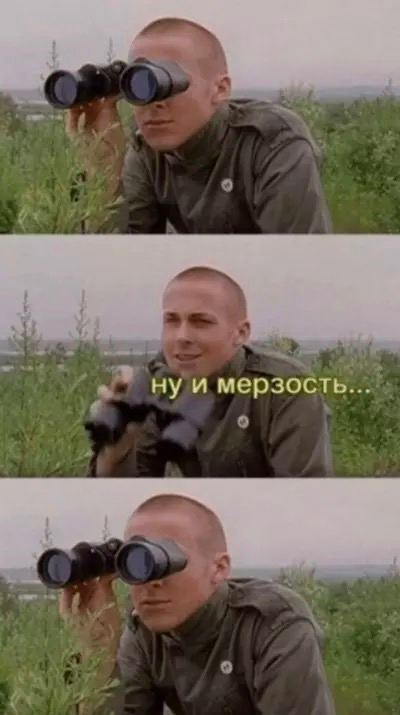

## 2. Приближение одномерной функции многочленом

Начнем с простой задачи.


1) Есть функция $f(x)$, но мы ее не знаем.

2) Зато мы знаем ее значения в $m$ точках (они называются тренировочным множеством):
$$f(x_1) = y_1$$
$$\cdots$$
$$f(x_m) = y_m$$
3) Нужно научиться приблизительно восстанавливать эту функцию.

Самый простой способ - научиться приближать её многочленом, а именно давайте подберем такие коэффициенты $a_0, a_1, \ldots, a_n$, чтобы многочлен $P(x) = a_0 + a_1x + a_2x^2 + \ldots + a_nx^n$ был как можно ближе к $f(x)$.

Но что такое "приблизить"? Мы знаем лишь значения в $m$ точках, так что в лучшем случае она должна проходить через все эти точки (хотя скоро мы увидим, что это не так).

В этом случае обычно пытаются минимизировать сумму квадратов ошибок во всех точках, то есть **функцию потерь** $$Q(P) = \sum_i (P(x_i) - f(x_i))^2 $$

Эту величину называют **MSE** - Mean Squared Error (средняя квадратичная ошибка).

Тут может возникнуть вопрос, почему мы берем именно сумму квадратов, а не, например, сумму модулей. Однозначного ответа на этот вопрос нет, наиболее удачный ответ, пожалуй такой: у суммы квадратов есть много удобных свойств, например это выпуклая, дифференцируемая функция. Тем не менее иногда другой выбор может быть оправданным. Если вам интересно чуть больше понять про смысл этих условий, можете решить такие задачи:

**(0.5 балла) Доп. Задача 1.** Найдите число m такое, что для заданных $x_i$ сумма $\sum|m - x_i|$ минимальна

$\frac{dQ}{dm} = \sum \frac{m - x_i}{|m-x_i|} = \sum \text{sgn}(m- x_i)$. Полученное выражение равна нулю, если число положительных элементов, равна числу отрицательных, то есть когда $m$ является медианой $x$.

**(0.5 балла) Доп. Задача 2.** Найдите число m такое, что для заданных $x_i$ сумма $\sum(m - x_i)^2$ минимальна


$\frac{dQ}{dm} = 2\sum_{i=1}^{n} (m - x_i) = 0 \longrightarrow m = \frac{\sum_{i=1}^{n} x_i}{n}$. Получается, что решением является среднее значение $x$.

Сейчас можно их и пропустить.


Сначала просто нарисуем какой-нибудь многочлен, например $f(x) = 3x^3 - 2x^2 + x$ на отрезке $[-1, 1]$:

In [11]:
def f(x):
    return 3 * x ** 3 - 2 * x**2 + x

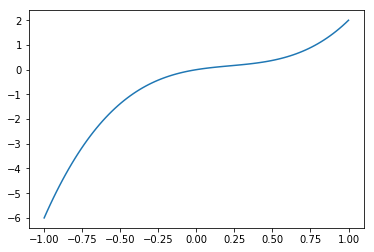

In [12]:
x100 = np.linspace(-1, 1, 100)
plt.plot(x100, f(x100))
plt.show()

Теперь зададим набор точек (10 штук) и посмотрим что будет, если подобрать по ним коэффициенты нашего многочлена:

In [13]:
x = np.linspace(-1, 1, 10)  # 10 точек на отрезке [-1, 1]
y = f(x)
coefs = np.polyfit(x, y, deg = 2)
coefs

array([-2.00000000e+00,  3.17037037e+00, -9.55004142e-16])

(это означает многочлен $-2x^2 + 3.17037 x$)

numpy позволяет легко работать с многочленами, заданными их коэффициентами. Мы можем создать из них объект poly1d, который можно будет просто вызывать для получения нужных значений:

In [14]:
poly = np.poly1d(coefs)
poly(0), poly(1), poly(2)

(-9.550041418833999e-16, 1.1703703703703716, -1.6592592592592554)

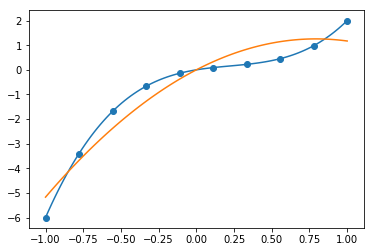

In [15]:
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

Довольно ожидаемо, наша функция (оранжевая) не очень похожа на то, что мы искали (синяя). Наверное зря мы пытаемся приблизить кубическую функцию многочленом второй степени. Давайте попробуем 3-ю степень.

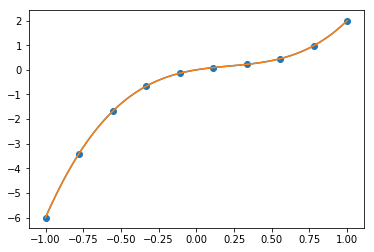

In [16]:
coefs = np.polyfit(x, y, deg = 3)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

На этот раз мы в точности угадали функцию. Можете проверить, что если увеличивать степень многочлена, результат не меняется: более высокие степени тут просто не нужны.

Но мы сейчас жили в идеальном мире. На практике чаще всего известные нам значения не совсем точны. Давайте добавим к значениям нашей функции немного шума:

In [17]:
def f_real(x):
    return 3 * x ** 3 - 2 * x**2 + x + np.random.normal(0, 1, x.shape)

In [18]:
x = np.linspace(-1, 1, 10)
y = f_real(x) # + np.random.normal(0, 0.5, 10)  # случайный шум

In [19]:
x100 = np.linspace(-1, 1, 100)

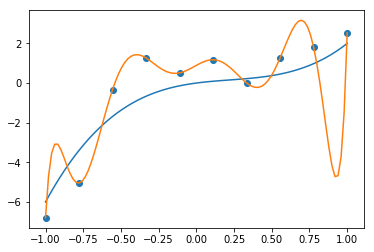

In [20]:
coefs = np.polyfit(x, y, deg = 10)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

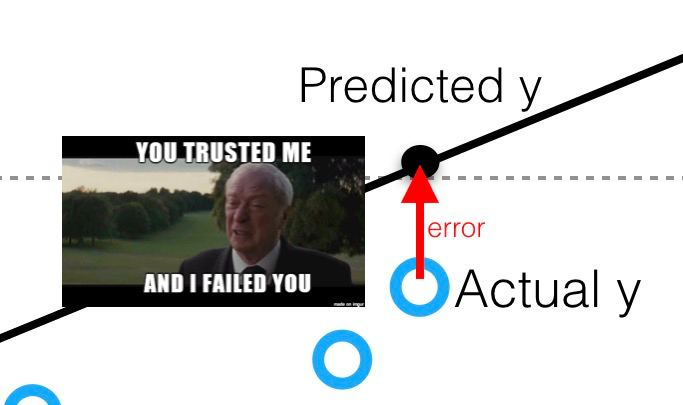

Теперь мы почти попали. Перед тем как читать дальше, подумайте над заданием.

**(1 балл) Обязательное задание 1:** попробуйте увеличить степень полинома. Что произойдет с графиком нашего приближения? Посмотрите  как обе функции себя ведут вне интервала x. Попробуйте сформулировать проблему, с которой мы столкнулись.

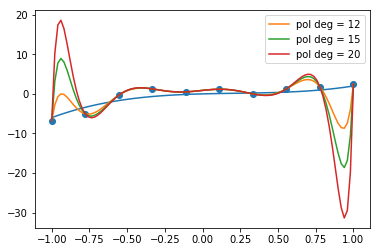

In [21]:
pol_degs = [12, 15, 20]
coeffs = [np.polyfit(x, y, deg = pdeg) for pdeg in pol_degs]
pols = [np.poly1d(c) for c in coeffs]

plt.scatter(x, y)
plt.plot(x100, f(x100))
for pdeg, p in zip(pol_degs, pols):
    plt.plot(x100, p(x100), label='pol deg = ' + str(pdeg))
plt.legend()
plt.show()

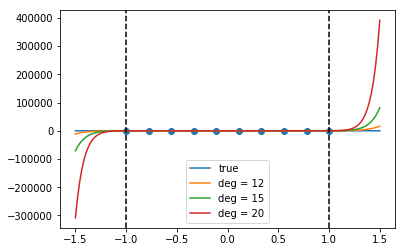

In [22]:
x_left = np.linspace(-1.5, -1, 25)
x_right = np.linspace(1, 1.5, 25)
x150 = np.concatenate((x_left, x100[1:-1], x_right))

plt.scatter(x, y)
plt.plot(x150, f(x150), label='true')
for pdeg, p in zip(pol_degs, pols):
    plt.plot(x150, p(x150), label=f'deg = {pdeg}')
plt.axvline(-1, linestyle='dashed', color='k')
plt.axvline(1, linestyle='dashed', color='k')
plt.legend()
plt.show()


При увеличении степени полинома феномен Рунге (осциляции) становится боле выраженным. Вне интервала найденные аппроксимции расходятся. То что мы наблюдаем здесь это не что иное, как переобучение.

## 3. Переобучение

То, что вы увидели при решении этого задания называется в машинном обучении **переобучением** (overfittig).

Если мы используем достаточно сложную модель (то есть модель, у которой много параметров, в нашем случае -- многочлен достаточно высокой степени), то у модели появляется возможность "выучить" все точки, которые она видела. Например, если задано $m$ точек, всегда можно подобрать многочлен степени $m-1$, который через них проходит (если вы не знакомы с этим фактом, можете подумать, как его доказать).


"Честный" способ проверять качество нашей апроксимации -- **смотреть точность в точках, которые мы не использовали при подборе многочлена**. Это множество часто называют тестовым множеством. Давайте зададим его так:

In [23]:
# возьмем 10 случайных точек от 0 до 1
x_test = np.random.random(10) 

# превратим их в 10 случайных точек от -1 до 1
x_test = 2 * x_test - 1
x_test

array([-0.01798919, -0.38112326,  0.41208581,  0.34271802, -0.45809646,
        0.29076709, -0.16530032, -0.59969743, -0.81889751,  0.42549909])

**(1 балл)  Обязательное задание 2:** напишите функцию, которая для данного многочлена считает его качество на тестовом множестве (то есть среднеквадратичное отклонение между значениями функции $f$ и многочлена $P$ на тестовой выборке).

Вы все прошлое занятие изучали разные функции, попробуйте сделать MSE как можно более компактной функцией (желательно в одну строчку).

In [24]:
# y_real - это np.array c реальными значениями в точках
# y_pred - это np.array c предсказанными нами значениями в точках
# они одной длины
def MSE(y_real, y_pred):
    return 1/y_real.size * np.linalg.norm(y_real - y_pred)**2

Убедимся, что правильно реализовали функцию для расчета MSE

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
y_real = f(x_test)
y_pred = [p(x_test) for p in pols]

mse_sklearn = mean_squared_error(y_real, y_pred[0])
mse_mine = MSE(y_real, y_pred[0])

print(mse_sklearn)
print(mse_mine)

1.342993067793228
1.3429930677932282


**(1 балл) Обязательное задание 3:** нарисуйте график зависимости ошибки на тестовом множестве от степени многочлена. При какой степени ошибка минимальна?


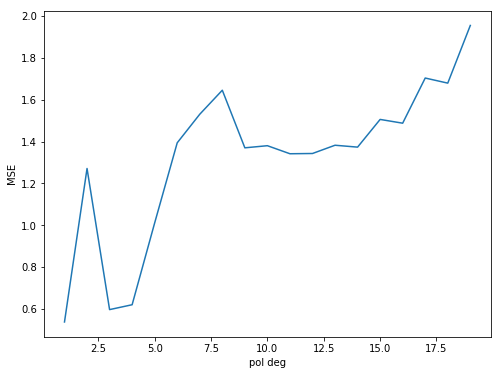

In [27]:
pol_degs = [k for k in range(1,20)]
coeffs = [np.polyfit(x, y, deg = pdeg) for pdeg in pol_degs]
pols = [np.poly1d(c) for c in coeffs]

y_pred = [p(x_test) for p in pols]
mses = [MSE(y_real, y_pred_k) for y_pred_k in y_pred]

_, ax = plt.subplots(figsize=(8,6))
ax.plot(pol_degs, mses)
ax.set_xlabel('pol deg')
ax.set_ylabel('MSE')
plt.show()

Ошибка минимальна при степенях 3-5, потому что полиномиальная аппроксимация не переобучается. 

**(1 балл) Доп. задача 5:** как меняется график, если увеличивать количество точек в множестве, на котором мы подбираем многочлен?

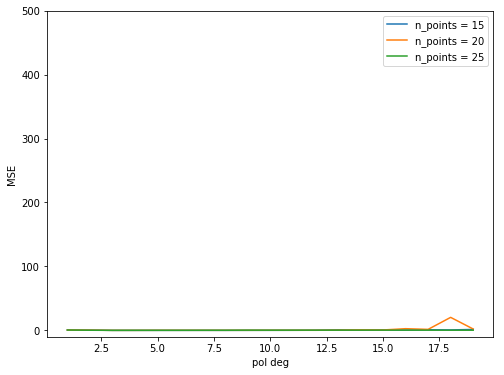

In [28]:
# место для решения
n_points = [k for k in range(15,30,5)]
x = [np.linspace(-1,1,n) for n in n_points]
y = [f_real(item) for item in x]

pol_degs = [k for k in range(1,20)]

coeffs = [[np.polyfit(xk, yk, deg = pdeg) for pdeg in pol_degs] for xk, yk in zip(x,y)]
pols = [[np.poly1d(c) for c in coeffsk] for coeffsk in coeffs]

y_pred = [[p(x_test) for p in polsk] for polsk in pols]
mses = [[MSE(y_real, y_hat) for y_hat in y_predk] for y_predk in y_pred]

_, ax = plt.subplots(figsize=(8,6))
for nps, item in zip(n_points, mses):
    ax.plot(pol_degs, item, label=f'n_points = {nps}')
ax.set_xlabel('pol deg')
ax.set_ylabel('MSE')
ax.set_ylim([-10, 5e+2])
ax.legend()
plt.show()

Если у нас больше данных для тренировки, то мы меньше переобучаемся.

## 4. Выводы

1. Цель машинного обучения с учителем - приблизить **целевую функцию** (target) по её значениям (возможно приблзительным) в некоторых точках.

В нашем случае - это $f(x) = 3x^3 - 2x^2 + x$. Обычно она, конечно, никому неизвестна.

2. Множество точек с известным значением функции называется **тренировочным множеством** (train).

В нашем случае - это 10 точек, выбранных равномерно на отрезке $[-1, 1]$.

3. Чтобы приблизить функцию, нужно использовать какую-то **модель** (model), приближающую функцию.

В данном случае - это многочлен $P(x) = a_0 + a_1x + a_2x^2 + \ldots + a_nx^n$.

4. Мы выбираем **функцию потерь** (loss function) для сравнения результатов модели и реальных значения на тренировочном множестве. Чем она меньше, тем лучше наша модель.

В данном случае - это $MSE = \sum_i (P(x_i) - f(x_i))^2$.

5. У модели есть **параметры**, которые мы выбираем так, чтобы функция потерь на тренировочном множестве была минимальна.

В данном случае - это коэффициенты многочлена ($a_0, a_1, \ldots, a_n$). Выбираются они с помощью пока магической для нас функции polyfit.

6. У модели есть **гиперпараметры**, которые мы выбираем сами.

В данном случае - это степень многочлена (число $n$).

7. Однако такой подход с минимизацией функции потерь может привести к тому, что мы идеально приблизим функцию на тренировочном множестве, но она будет абсолютно отличаться во всех остальных точках. Это явление называется **переобучением**.

В данном случае - мы видели, что если степень многочлена большая (больше трех), то мы попадаем во все точки, но при этом сам многочлен сильно отличается от $f(x)$.

8. Чтобы бороться с переобучением, полезно выделить **тестовое множество** точек, в которых мы тоже знаем результаты функции. Оно никак не используется при обучении модели, и нужно только для валидации результата.

В данном случае - мы взяли рандомные 10 точек на отрезке $[-1, 1]$.

9. В идеальном случае функция потерь на тренировочном и тестовом множестве не отличается. А вот если на тренировочном функция потерь получается гораздо меньше, чем на тестовом, то это говорит о том, что происходит переобучение.

Действительно, при большой степени MSE близка к или равна нулю на тренировочном множестве, а на тестовом множестве нет.

10. Единственный пока способ, который мы знаем, чтобы влиять на переобучение - это перебирать **гиперпараметры** модели так, чтобы **минимизировать функцию потерь на тестовом множестве**.

Действительно, если выбрать степень 3, то функция потерь окажется минимальной на тестовом множестве, как мы видели в задании 3.

## 5. Разделение на тренировочную и тестовую части

Если вы решите поучаствовать в каком-нибудь соревновании по машинному обучению, вы увидите, что тестовое множество вам недоступно (иначе было бы неинтересно: очень легко обучиться предсказывать то, что ты уже видел).

В реальной жизни обычно тоже считают, что на тестовом множестве можно провериться один раз -- в самом конце. Иначе вы начнете подкручивать гиперпараметры глядя на результат на тестовой выборке и, сами того не замечая, переобучитесь.

Как поступать в такой ситуации? Придется пожертвовать частью точек, которые даны нам для обучения и использовать их для подбора гиперпараметров в нашем алгоритме (в нашем случае это степень многочлена).

То есть придется из точек, у которых мы знаем результаты, убрать, например, 10% в тестовое множество.

Функция для этого есть, например, в пакете sklearn

In [29]:
X = np.linspace(-1, 1, 50)
y = f_real(X)

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [31]:
X_train, y_train

(array([-0.67346939, -0.3877551 ,  0.30612245,  0.55102041,  0.91836735,
        -0.87755102,  0.14285714, -0.46938776, -0.63265306, -0.91836735,
         0.59183673,  0.79591837,  0.83673469, -0.79591837, -0.51020408,
         0.3877551 , -0.10204082,  0.51020408,  0.46938776, -0.06122449,
         0.95918367, -0.75510204,  1.        , -0.02040816,  0.10204082,
        -0.55102041,  0.63265306, -0.2244898 ,  0.34693878,  0.67346939,
        -0.95918367,  0.71428571,  0.2244898 ,  0.02040816, -0.59183673,
         0.42857143,  0.26530612, -1.        , -0.42857143, -0.83673469,
         0.06122449, -0.26530612,  0.18367347, -0.18367347, -0.30612245]),
 array([-2.74724773,  0.62426745, -0.03734885,  0.03121694,  1.2912856 ,
        -4.25350022, -1.56008947,  1.15492504, -2.91310552, -5.00428703,
         0.23579704, -0.33665472, -0.57633956, -3.07776148,  1.50429286,
        -1.11618927, -0.71483354,  0.95660467,  1.93764388, -0.1661848 ,
         2.67896424, -5.01431858,  2.45616955, -0

In [32]:
X_test, y_test

(array([-0.71428571,  0.75510204, -0.34693878,  0.87755102, -0.14285714]),
 array([-1.19205807,  1.26997273, -2.66824189,  1.872682  , -2.80241834]))

## 6. Кросс-валидация

Также есть более точный способ проводить валидацию результата. Если разделить множество один раз на тестовое и тренировочное, то это может значительно влиять на результат. Вдруг в тестовое множество случайно попали такие точки, в которых предсказать значение тяжелее или легче, чем обычно?

Тогда можно применить **кросс-валидацию** - давайте разделим множество на 10 примерно равных частей, тогда у нас есть 10 разделений на тренировочное и тестовое множество - как тестовое множество выберем по очереди каждую из этих частей, а как тренировочное выберем все остальные части. В итоге, все элементы множества побывают и в тренировочной, и в тестовой чати.

Можно посчитать результат на каждом из 10 разбиений и просто усреднить результат.


In [33]:
# Есть вот такая удобная штука
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    print(test_index, train_index)

[0 1 2 3 4] [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[5 6 7 8 9] [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[10 11 12 13 14] [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[15 16 17 18 19] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[20 21 22 23 24] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[25 26 27 28 29] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[30 31 32 33 34] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

**(1 балл) Доп. задача 6:** проделайте все вышеописанное с функцией $f(x) = \frac{1}{1 + e^{-x}}$ на отрезке $[-3, 3]$. Как оптимальная степень зависит от количества точек, по которым вы подбираете многочлен?

1. Построить заданную функцию

2. Взять 10 точек от -3 до 3 и приближать её полиномом разной степени, построить график ошибки

3. Взять 10 случайных точек от -3 до 3 и посмотреть ошибку на этих точках полиномиальных функций обученных по пункту 2 (т.е. взять тренировочные точки для обучения из пункта 2, а тестировать случайными точками) построить график.

4. Добавить в функцию случайный шум и проделать пункты 2 и 3 для неё.

5. Увеличить количество тренировочных(только тренировочных) точек с 10 например до 20 40 60. И проделать пункты 2 и 3, для этих сэмплов

6. Сделать выводы.

In [34]:
def f_task6(x, add_noise=False):
    if add_noise:
        return 1/(1 + np.exp(-x)) + np.random.normal(0, 0.1, x.shape)
    else:
        return 1/(1 + np.exp(-x))

def visualize_fcn(x,y,type='plot', xy_labels=None):
    assert(type=='plot' or type=='scatter')
    _, ax = plt.subplots()
    if type=='plot':
        ax.plot(x, y)
    else:
        ax.scatter(x,y)
    if xy_labels is not None:
        ax.set_xlabel(xy_labels[0])
        ax.set_ylabel(xy_labels[1])
    plt.show()

Отрисуем функцию

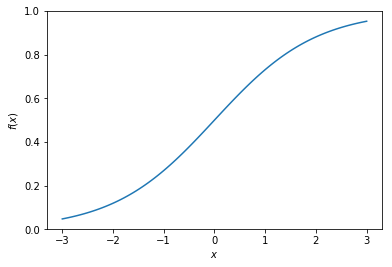

In [35]:
x100 = np.linspace(-3,3, 100)
y100 = f_task6(x100)

visualize_fcn(x100, y100, xy_labels=[r'$x$', r'$f(x)$'])

Выберем 10 точек, равномерно распределенных от -3 до 3 для обучения и визуализируем эти точки

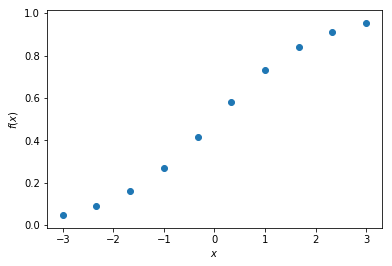

In [36]:
x10 = np.linspace(-3,3,10)
y10 = f_task6(x10)

visualize_fcn(x10, y10, 'scatter', xy_labels=[r'$x$', r'$f(x)$'])

Обучим модели (найдем коэффициенты аппроксимирующего полинома) для разных значений гиперпараметра - степени полинома

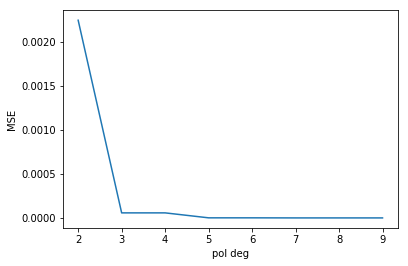

In [37]:
# define polynomial degrees
pol_degs = [k for k in range(2,10)]

# fit polynomials
coeffs = [np.polyfit(x10, y10, deg = pdeg) for pdeg in pol_degs]
pols = [np.poly1d(c) for c in coeffs]

# compute MSE
y_pred = [p(x10) for p in pols]
mses_train = [MSE(y10, yk) for yk in y_pred]

# visualize MSE as a function of polynomial degree
visualize_fcn(pol_degs, mses_train, 'plot', xy_labels=[r'pol deg', r'MSE'])

Проверим модель на тестировочных данных

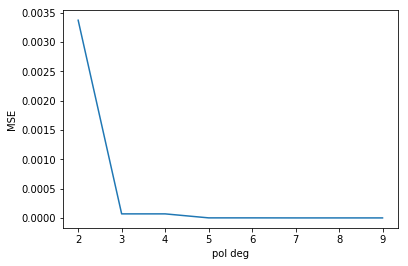

In [38]:
# generate test set
x_test10 = np.random.random(10)
x_test10 = x_test10*6 - 3
y_test10 = f_task6(x_test10)

# compute MSE
y_pred_test = [p(x_test10) for p in pols]
mses_test = [MSE(y_test10, yk) for yk in y_pred_test]

# visualize MSE as a function of polynomial degree
visualize_fcn(pol_degs, mses_test, 'plot', xy_labels=[r'pol deg', r'MSE'])

Добавим шум в функцию и повторим процесс обучения и тестировки

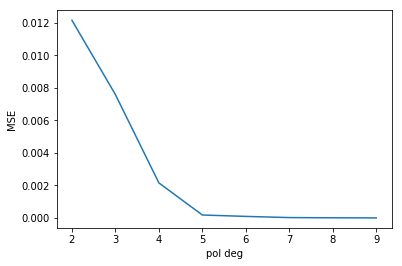

In [39]:
# function values
y10_n = f_task6(x10, add_noise=True)

# fit polynomials
coeffs = [np.polyfit(x10, y10_n, deg = pdeg) for pdeg in pol_degs]
pols = [np.poly1d(c) for c in coeffs]

# predict
y_pred = [p(x10) for p in pols]

# compute mse
mses_train = [MSE(y10_n, yk) for yk in y_pred]

visualize_fcn(pol_degs, mses_train, 'plot', xy_labels=[r'pol deg', r'MSE'])

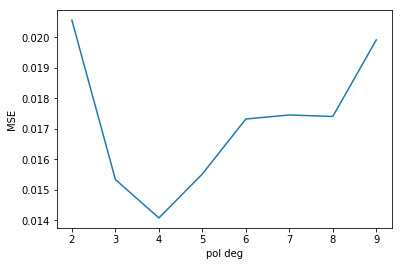

In [40]:
# function values for test set
y_test10 = f_task6(x_test10, add_noise=True)

# predict
y_pred = [p(x_test10) for p in pols]

# compute mse
mses_test = [MSE(y_test10, yk) for yk in y_pred]

visualize_fcn(pol_degs, mses_test, 'plot', xy_labels=[r'pol deg', r'MSE'])

Проверим что произойдет если мы увеличим количество примеров в тренировочном датасете

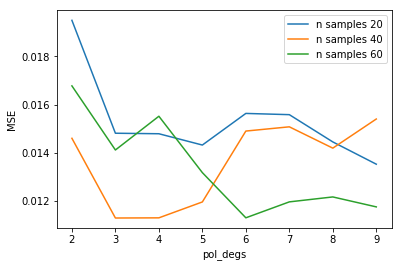

In [41]:
# generate data for different number of samples
n_train_samples = [20, 40, 60]
x_train = [np.linspace(-3,3,num) for num in n_train_samples]
y_train = [f_task6(x, add_noise=True) for x in x_train]

# fit polynomials
coeffs = [[np.polyfit(x_train_k, y_train_k, deg = pdeg) for pdeg in pol_degs] for x_train_k, y_train_k in zip(x_train, y_train)]
pols = [[np.poly1d(c) for c in coeff] for coeff in coeffs]

# predict
y_pred = [[p(x_test10) for p in pol] for pol in pols]

# compute mse
mses_train = [[MSE(y_test10, yk) for yk in y_pred_k] for y_pred_k in y_pred]

# visualize
_, ax = plt.subplots()
for l, item in zip(n_train_samples, mses_train):
    ax.plot(pol_degs, item, label='n samples '+str(l))
ax.set_xlabel('pol_degs')
ax.set_ylabel('MSE')
ax.legend()
plt.show()

#### Выводы

Полиномы степеней 3 и более хорошо аппроксимируют заданную функцию (сигмоиду на отрезке от -3 до 3). 
В случае когда выход функции не зашумлен, значение MSE для тестовом датасете не сильно отличается от значений MSE для тренировочного датасета. 
Получается те 10 точек, которые нам даны для тренировки идеально описывают функцию, которую мы хотим аппроксимировать, поэтому MSE не падает. 
Когда выход функции зашумлен, то картина координально меняется, мы видим, что наша модель переобучается. 
MSE на тестовом датасете сильно отличается от тренировочного, особенно для полниномов высоких степеней.
Если увеличить количество данных в тренировочном датасете, то можно улучшить модель, переобучение уменьшится. Иными словами чем больше данных, тем меньше переобучение.


## 7. Линейная регрессия на реальных данных

До этого мы учились приближать одномерную функцию многочленом. Каждая точка имела ровно один признак - коодинату $x$.

Тем не менее, чаще всего в машинном обучении признаков гораздо больше. Возьмем какой-нибудь реальный датасет.

In [42]:
# https://drive.google.com/file/d/13kQUcl-N3ag6NXEm-QWjdUiuHO4-LOxb/view?usp=sharing
!gdown 13kQUcl-N3ag6NXEm-QWjdUiuHO4-LOxb

Downloading...
From: https://drive.google.com/uc?id=13kQUcl-N3ag6NXEm-QWjdUiuHO4-LOxb
To: /home/shamil/Desktop/career/courses/tinkoff DL/Sample-ML-Repo/06. Overfittng problem/Advertising.csv
100%|██████████████████████████████████████| 5.17k/5.17k [00:00<00:00, 10.8MB/s]


In [43]:
data = pd.read_csv('Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


В датасете показаны результаты продаж разных товаров в зависимости от ресурсов (тысяч долларов), которые вложили в различные средства распространения информации:
* TV - реклама по телевизору
* radio - на радио
* newspapers - в газетах

Целевая переменная:

sales - продажи такого-то товара (тысячи штук)

In [44]:
# Размеры датасета
data.shape

(200, 4)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


In [46]:
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


Признаков немного, поэтому давайте попробуем визуализиовать зависимость целевой переменной от каждого из признаков.

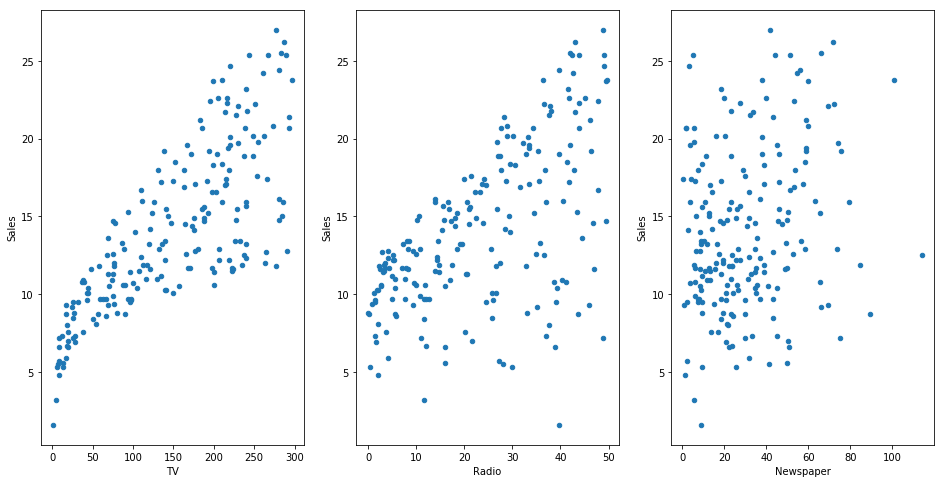

In [47]:
fig, axs = plt.subplots(1, 3,)
data.plot(kind='scatter', x='TV', y='Sales', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])
plt.show()

### Простая линейная регрессия

Из графиков выше предположим, что только размер рекламы на телевизоре влияет на продажи больше всего. Формула для такого случая выглядит следующим образом:
$$y=\beta_0+\beta_1x$$
Здесь:
* $y$ - наше предсказание продаж
* $x$ - сколько денег вложили в рекламу по телевидению
* $\beta_0$ - сдвиг
* $\beta_1$ - параметр, отвечающий за важность признака x

$\beta_0$ и $\beta_1$ - это параметры нашей модели. Чтобы создать хорошую модель, надо "обучить" эти значения. Т.е. изменить их так, чтобы они хорошо работали для нашей задачи.

### Обучение коэффициентов модели

Параметры $\beta_0$ и $\beta_1$ подбираются таким образом, чтобы минимизировать **сумму наименьших квадратов ошибок**:

$$Q(MSE)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2$$

<img src="https://i.pinimg.com/originals/95/99/b0/9599b04198dc617282026d00a6e8f9d4.png">

* Фиолетовые точки на даграмме $y^{true}$ - это полученные истинные значения x и y .
* Синяя линия $y^{pred}$ - это наша модель: линия, которой мы стараемся приблизить данные .
* Красные отрезки - это ошибки нашей модели.


Как коэффициенты $\beta_0$ и $\beta_1$ соотносятся с синей линией:
* $\beta_0$ - это сдвиг нашей прямой, т.е. значение y при x = 0.
* $\beta_1$ - это тангенс угла наклона прямой.

Как искать данные коэффициенты? Есть много техник: аналитическое решение, методы основанные на градиентном спуске. Пока же достаточно знать, что многие библиотеки (в том числе и sklearn) умеют это делать. Зачем кожаному мешку напрягаться :)

In [48]:
from sklearn.linear_model import LinearRegression

# Наша модель
reg = LinearRegression()

# Подготовим данные для неё
# На вход требуется 2D матрица, а у нас только один признак,
# и надо превратить его из 1D вектора (n,) в 2D матрицу (n, 1).
# Это можно сделать с помощью метода reshape
x = data["TV"].values.reshape(-1, 1) 
y = data["Sales"].values

# Обучаем нашу модель
reg.fit(x, y)

# Коэффициенты
print("Сдвиг={}".format(reg.intercept_))
print("Массив коэффициентов={}".format(reg.coef_))

Сдвиг=7.032593549127695
Массив коэффициентов=[0.04753664]


### Интерпретируем коэффициенты
Что означает коэффициент, связанный с телевидением ($\beta_1$)?
* Дополнительные 1000 000$, вложенные на в рекламу на телевидении, позволят продажам товара вырасти где-то на 0.047 * 1000 = 47 тысяч единиц.

In [49]:
# Посчитаем ручками
7.032594 + 0.047537*1000

54.56959400000001

In [50]:
X_new = pd.DataFrame({'TV': [1000]})
X_new.head()

,TV
0,1000


In [51]:
reg.predict(X_new)

array([54.56923398])

### Нарисуем нашу прямую

In [52]:
# Возьмём предсказания для данных, на которых обучались
y_pred = reg.predict(x)
y_pred.shape

(200,)

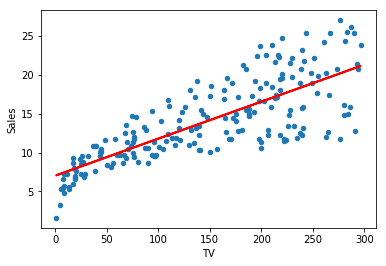

In [53]:
# Сначала выведем истинные данные
data.plot(kind='scatter', x='TV', y='Sales')

# Теперь рисуем нашу линию
plt.plot(x, y_pred, c='red', linewidth=2)
plt.show()

Посчитаем ошибку MSE на обучающей выборке:


In [54]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_pred, y))

10.512652915656757


### Используем все признаки

Простую линейную регрессию с одним признаком можно легко расширить на случай нескольких признаков:
$$y=\beta_0+\beta_1x_1+...+\beta_nx_n$$

А для нашего датасета это будет выглядеть так:
$$Sales=\beta_0+\beta_1*TV+\beta_2*radio+\beta_3*newspaper$$

Давайте опять воспользуемся sklearn, чтобы их оценить:

In [55]:
reg = LinearRegression()

X = data.drop("Sales", axis=1)
y = data["Sales"]

# Обучаем нашу модель
reg.fit(X, y)

# Коэффициенты
print("Сдвиг = {}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {} = {}".format(column, coef))

Сдвиг = 2.938889369459412
Коэффициент для TV = 0.0457646454553976
Коэффициент для Radio = 0.18853001691820448
Коэффициент для Newspaper = -0.0010374930424763285


Вес признака отвечает также, как и в предыдущем случае за значимость этого признака. Для газет он вообще отрицательный. Вычислим ошибку на обучающей выборке.

In [56]:
y_pred = reg.predict(X)

# Ошибка теперь равна:
print(mean_squared_error(y_pred, y))

2.784126314510936


Ошибка уже меньше, чем при одном признаке, однако измерять ошибку на обучающей выборке неправильно. Помимо истинной зависимости между признаками и целевой переменной, туда могут затесаться случайности, лишние данные и прочие факторы. Если не ограничивать каким-то образом модель (об этом мы узнаем позднее), то модель легко подстраивается под эти шумы. Она начинает показывать очень хорошее качество на обучающей выборке, но когда мы попробуем посмотреть качество на других выборках, то там модель будет показывать себя плохо. Это и есть переобучение.

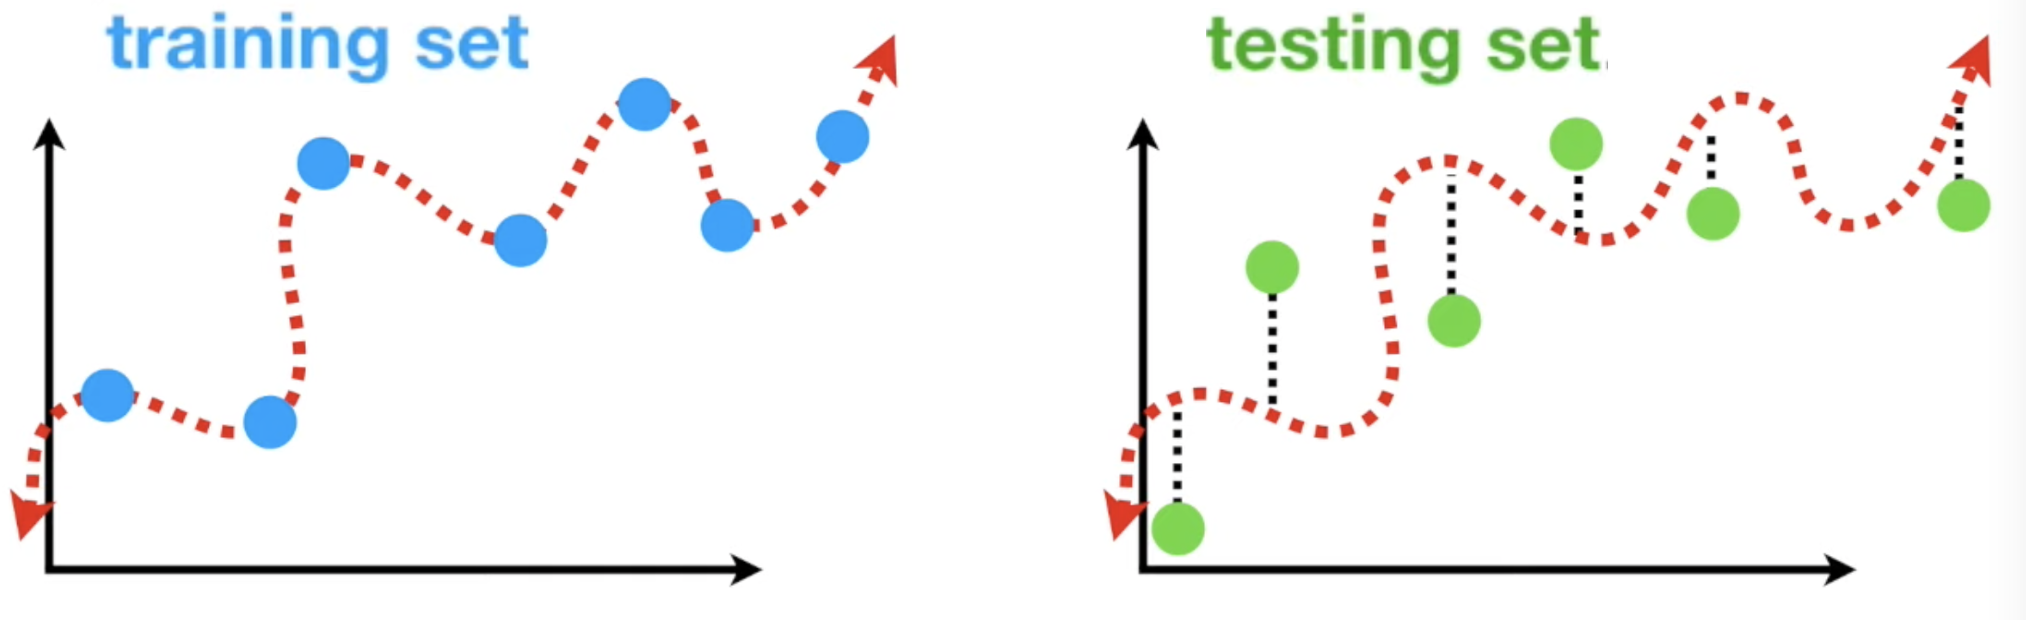

Поэтому применим кросс-валидацию:

In [57]:
# Многие выбирают k=5 для начала
k = 5
errors = []

X = data.drop("Sales", axis=1)
y = data["Sales"]

# Размер одной части
fold_size = len(X) // k
print(fold_size)

for i in range(k):
    # Берём все значения, кроме выбранной части
    X_train = X[:i * fold_size].append(X[(i + 1) * fold_size:])
    y_train = y[:i * fold_size].append(y[(i + 1) * fold_size:])
    
    # Берём выбранную часть
    X_test = X[i * fold_size:(i + 1) * fold_size]
    y_test = y[i * fold_size:(i + 1) * fold_size]
    
    # На каждой итерации обучаемся отдельно и сохраняем ошибку
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    errors.append(mean_squared_error(y_pred, y_test))
    
# Выводим ошибку на кросс-валидации
print(np.mean(errors))

40
3.0729465971002106


In [58]:
# А можно не париться и попросить sklearn всё сделать за нас
from sklearn.model_selection import cross_val_score

# Берём с отрицательным знаком, т.к. обычно туда передаётся не функция потерь, которую надо минимизировать
# А что-то вроде "функции успеха", которую надо максимизировать
errors = -cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
print(np.mean(errors))

3.0729465971002106


Видно, что ошибка больше, чем тогда на обучающей выборке, поэтому есть показания думать, что это переобучение. Отчего оно обычно происходит? Мы берём слишком много лишних признаков или делаем модель слишком сложной для данной задачи. Для решения этой задачи существует регуляризация.

### Регуляризация

Регуляризация - это искусстенное занижение всех параметров моделей ($\beta_0,\beta_1,...$). Это помогает упростить модель, т.к. низкие значения $\beta_i$ означают, что модель будет выдавать результаты близкие к прямой (или гиперплоскости, если параметров много). А также зануление некоторых коэффициентов может убрать ненужные признаки из обучения. Однако как всё это сделать так, чтобы не убрать нужные признаки?

Посмотрим на функцию потерь, которую мы минимизируем:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2$$

Добавим туда слагаемое, которое поможет нам понизить значения наших $\beta_i$:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2 + \lambda \sum_{i=1}^m\beta_i^2$$

Действительно, если мы будем понижать нашу функцию потерь $L(\beta)$, то мы будем минимизировать и второе слагаемое, которое и отвечает за абсолютные величины $\beta_i$. Осталось указать, что $\lambda$ это некоторый числовой коэффициент, который позволяет играться между очень сильной и очень слабой регуляризацией. Если он большой, то регуляризация сильная и модель будет более простой, меньше переобучаться, больше недообучаться, и наоброт. 

Забыл добавить, что это была L2-регуляризация.
L1-регуляризация выглядит так:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2 + \lambda \sum_{i=1}^m|\beta_i|$$
Она отличается от L2 тем, что она обнуляет некоторые коэффициенты, а L2 пытается всё уменьшать равномерно.

В sklearn L1-регуляризация - это Lasso, а L2-регуляризация - это Ridge. Давайте посмотрим, какое качество они нам дадут на кросс-валидации.

In [59]:
# L1
from sklearn.linear_model import Lasso

reg = Lasso( ).fit(X, y)

# Посмотрим на коэффициенты модели
# Коэффициенты
print("Сдвиг={}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {}={}".format(column, coef))
print()

errors = -cross_val_score(Lasso(), X, y, cv=5, scoring='neg_mean_squared_error')
print("Результат={}".format(np.mean(errors)))

Сдвиг=3.040215583480375
Коэффициент для TV=0.045661415380019485
Коэффициент для Radio=0.1834643975886825
Коэффициент для Newspaper=0.0

Результат=3.041405896751369


Видно, что признак с рекламой в газетах модель захотела полностью убрать из выборки.

In [60]:
# L2
from sklearn.linear_model import Ridge

reg = Ridge( ).fit(X, y)

# Посмотрим на коэффициенты модели
# Коэффициенты
print("Сдвиг = {}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {} = {}".format(column, coef))
print()

errors = -cross_val_score(Ridge(), X, y, cv=5, scoring='neg_mean_squared_error')
print("Результат={}".format(np.mean(errors)))

Сдвиг = 2.9389674583301506
Коэффициент для TV = 0.045764643658018474
Коэффициент для Radio = 0.18852509681078544
Коэффициент для Newspaper = -0.0010362939589070004

Результат=3.072932673298496


In [ ]:
reg.coef_

array([ 0.04576464,  0.1885251 , -0.00103629])

Тут модель полностью не зануляла все признаки, а уменьшила их веса некоторых из них, а некоторых увеличила. Но изменения были столь незначительные, что качество не изменилось.

Как видно, качество не сильно улучшилось. Это всё потому что, мы не подбирали параметр параметр lambda (в моделях он называется alpha), а оставили его равным 1.0. Вот тут нам и приходит на помощь кросс-валидация.

Попробуем сначала Lasso. Давайте сначала поступим по тупому, и будем выбирать параметр lambda на обучающей выборке.

In [62]:
lambdas = np.arange(0.1, 3.0, 0.2)
# Выведем доступные lambda
print("Все лямбды:")
print(lambdas)

# Лямбды и их ошибки на обучающей выборке
lambda_errors = []

# Проходим по всем лямбдам и записываем ошибки на обучающей выборке
for val in lambdas:
    reg = Lasso(alpha=val).fit(X, y)
    y_pred = reg.predict(X)
    # Сохраняем ошибку на обучающей выборке
    lambda_errors.append((val, mean_squared_error(y_pred, y)))
    print(((val, mean_squared_error(y_pred, y))))
    

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])

# Вычислим ошибку на кросс-валидации
# Лучшая модель
best_reg = Lasso(alpha=min_val)
cv_error = -np.mean(cross_val_score(best_reg, X, y, cv=5, scoring='neg_mean_squared_error'))

print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, cv_error))

Все лямбды:
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9]
(0.1, 2.7842286851696865)
(0.30000000000000004, 2.784985993046452)
(0.5000000000000001, 2.7857256993570276)
(0.7000000000000001, 2.7868352725638887)
(0.9000000000000001, 2.7883147049707757)
(1.1000000000000003, 2.7901639965776877)
(1.3000000000000003, 2.7923831473846246)
(1.5000000000000004, 2.7949721573915873)
(1.7000000000000004, 2.7979310265985737)
(1.9000000000000004, 2.801259755005587)
(2.1000000000000005, 2.804958342612624)
(2.3000000000000007, 2.8090267894196854)
(2.5000000000000004, 2.813465095426774)
(2.7000000000000006, 2.8182732606338856)
(2.900000000000001, 2.8234512850410236)

Оптимальная lambda:
Lambda=0.10, результат=3.07


А теперь сделайте так, чтобы сохранялась ошибка не на обучающей выборке, а на кросс-валдиации (cross_val_score) и минимум выбирался из неё. 

**(0.5 балла) Обязательное задание 4:** нарисуйте график зависимости ошибки на тестовом множестве от коэффициента регуляризации. При какой степени ошибка минимальна?

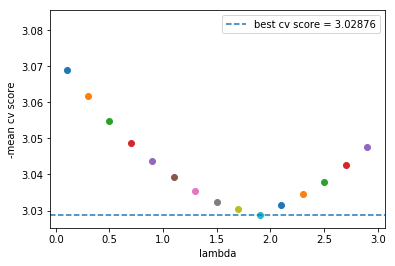


Оптимальная lambda на основе кросс-валидации:
Lambda=1.90, результат=3.02876


In [84]:
# choose range for lambdas
lambdas = np.arange(0.1, 3.0, 0.2)

lambda_errors = []

for l in lambdas:
    errors = -cross_val_score(Lasso(alpha=l), X, y, cv=5, scoring='neg_mean_squared_error')
    lambda_errors.append((l, np.mean(errors)))
    # print(f'lamda = {l:.3f}, mean_cross_val_score = {np.mean(errors):.5f}')

best_lambda, best_cv_score = min(lambda_errors, key=lambda x: x[1])

_, ax = plt.subplots()
for item in lambda_errors:
    ax.scatter(item[0], item[1])
ax.axhline(best_cv_score, linestyle='dashed', label=f'best cv score = {best_cv_score:.5f}')
ax.set_xlabel('lambda')
ax.set_ylabel('-mean cv score')
ax.legend()
plt.show()

print("\nОптимальная lambda на основе кросс-валидации:")
print(f"Lambda={best_lambda:.2f}, результат={best_cv_score:.5f}")

**(0.5 балла) Обязательное задание 5:** Сделайте то же самое для L2-регуляризации:

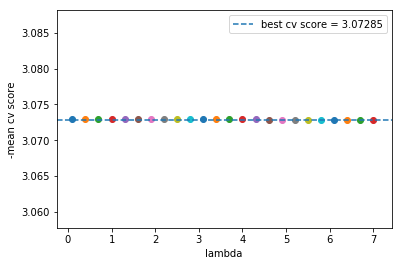


Оптимальная lambda на основе кросс-валидации:
Lambda=7.00, результат=3.07285


In [94]:
# choose a range for lambdas of ridge regression
lambdas = np.arange(0.1, 7.0, 0.3)

lambda_errors = []

for l in lambdas:
    errors = -cross_val_score(Ridge(alpha=l), X, y, cv=5, scoring='neg_mean_squared_error')
    lambda_errors.append((l, np.mean(errors)))
    # print(f'lamda = {l:.3f}, mean_cross_val_score = {np.mean(errors):.5f}')

best_lambda, best_cv_score = min(lambda_errors, key=lambda x: x[1])

_, ax = plt.subplots()
for item in lambda_errors:
    ax.scatter(item[0], item[1])
ax.axhline(best_cv_score, linestyle='dashed', label=f'best cv score = {best_cv_score:.5f}')
ax.set_xlabel('lambda')
ax.set_ylabel('-mean cv score')
ax.legend()
plt.show()

print("\nОптимальная lambda на основе кросс-валидации:")
print(f"Lambda={best_lambda:.2f}, результат={best_cv_score:.5f}")

#### Выводы
На самом деле наличие L2-регуляризации не особо улучшает модель, поэтому ее можно вообще убрать. Однако L1-регуляризация внесла небольшое улучшение, поэтому в для данного датасета лучше использовать ее.

Если всё было правильно, то данные манипуляции помогут немного улучшить качество вашей модели. Это поднимет вас на несколько мест в соревнованиях, или вашему работодателю даст побольше прибыли.

## P.S. meme

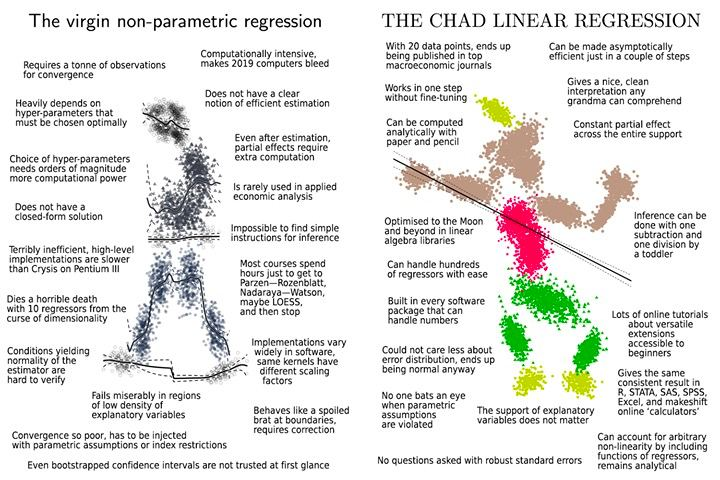

## Дополнительные материалы для самостоятельного изучения

* Визуальное представление основ линейной алгебры [здесь](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab). (рус. субтитры)

* Визуальное представление основ математического анализа [здесь](https://www.youtube.com/playlist?list=PLZHQObOWTQDMsr9K-rj53DwVRMYO3t5Yr). (рус. субтитры)

# Основное домашнее задание (6 баллов + гешефт за улучшения)

In [166]:
# https://drive.google.com/file/d/1dXl0DeoYG1mkXya6mDpaY0NhbcbI17Nu/view?usp=sharing
! gdown --id 1dXl0DeoYG1mkXya6mDpaY0NhbcbI17Nu

/home/shamil/.local/lib/python3.6/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dXl0DeoYG1mkXya6mDpaY0NhbcbI17Nu
To: /home/shamil/Desktop/career/courses/tinkoff DL/Sample-ML-Repo/06. Overfittng problem/diabetes.data.csv
100%|██████████████████████████████████████| 18.5k/18.5k [00:00<00:00, 21.6MB/s]


Для домашнего задания вы используете другой датасет.

In [167]:
data = pd.read_csv('diabetes.data.csv', sep='\t')
data.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


В датасете приводится информация о пациентах и их состоянии при заболевании диабетом. Описание признаков можно прочитать [здесь](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html). Колонка Y - целевая переменная:

In [ ]:
target = 'Y'
X = data.drop([target], axis=1)
y = data[target]

X.shape, y.shape

((442, 10), (442,))

**Ваша задача** - провести то же исследование, что и в датасете в самом начале (Sales ~ TV, Radio, Newspaper). В итоге, нужно получить модель линейной регрессии, качество которой надо вывести с помощью cross_val_score с метрикой MSE (тоже самое в общем).

**Целевая метрика - MSE**

За каждое достойное улучшение качества на cross_val_score будут доп. баллы. Не забудьте описать, что использовали, что получилось и нет, а также попробуйте понять почему. Побольше гуглите. 

Возможные улучшения:
* Нормализация данных: вычитаем из каждой колонки её среднее и делим на стандартное отклонение.
* Пробуйте убрать ненужные признаки.
* Можно перемножать некоторые признаки.
* Погуглите что-то вроде "improve linear regression".

В общем, представьте, что вы работаете датасаентистом, получаете *300K bucks*, а вам сказали, что нужно как можно лучше уметь предсказывать такие данные.

<img src="https://c.tenor.com/JZ1XdjdbHs8AAAAC/futurama-fry.gifhttps://c.tenor.com/3M8C_1GPijcAAAAC/master-gachi.gif">

In [ ]:
# pip install drawdata

In [ ]:
# from drawdata import draw_scatter
# draw_scatter()